In [1]:
import sys
sys.path.insert(0, "..")

# MTCNN RNet

This notebook demonstrates the RNet architecture and its corresponding weights.

RNet is a convolutional neural network (CNN) with fully connected layers (FC) used in the second stage of MTCNN. This network refines the bounding box proposals generated by the previous PNet stage. It produces two outputs:

* Regression of the bounding box coordinates to further refine the initial proposals.
* Classification of the proposals into two categories: no-face or face.

The outputs are generated for each bounding box proposal, refining the results from the previous stage.  
While RNet has the same functionality as PNet, it processes each proposal individually, with a fixed-size input, using the crops from the output of the previous stage as input.

In the following sections, we will run the MTCNN model, focusing solely on the RNet stage. We will examine the intermediate inputs, observe the output shapes, and visualize the results.

## MTCNN on RNet Stage

MTCNN can be configured to run up to the second stage, which will provide the direct output of the RNet stage.

In [2]:
from mtcnn import MTCNN
from mtcnn.utils.images import load_image
from mtcnn.stages import StagePNet, StageRNet

2024-10-02 19:09:03.399323: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-02 19:09:03.409085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 19:09:03.421049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 19:09:03.424652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 19:09:03.433483: I tensorflow/core/platform/cpu_feature_guar

In [3]:
image = load_image("../resources/ivan.jpg")

2024-10-02 19:09:04.860887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1044 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-10-02 19:09:04.861271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7363 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:17:00.0, compute capability: 6.1


In [4]:
mtcnn = MTCNN(stages=[StagePNet, StageRNet], device="CPU:0")

In [5]:
%%time
result = mtcnn.detect_faces(image, postprocess=True)

CPU times: user 614 ms, sys: 163 ms, total: 776 ms
Wall time: 415 ms


In [6]:
result

[{'box': [269, 92, 67, 67], 'confidence': 0.9900748133659363},
 {'box': [478, 280, 60, 60], 'confidence': 0.9535849094390869},
 {'box': [100, 407, 42, 42], 'confidence': 0.9220193028450012},
 {'box': [9, 72, 30, 30], 'confidence': 0.9089504480361938},
 {'box': [486, 205, 61, 61], 'confidence': 0.8844603896141052},
 {'box': [7, 71, 43, 43], 'confidence': 0.8773281574249268},
 {'box': [187, 119, 32, 32], 'confidence': 0.7967076897621155},
 {'box': [305, 181, 48, 48], 'confidence': 0.7636563181877136},
 {'box': [279, 104, 50, 50], 'confidence': 0.7341133952140808},
 {'box': [176, 134, 58, 58], 'confidence': 0.7229615449905396}]

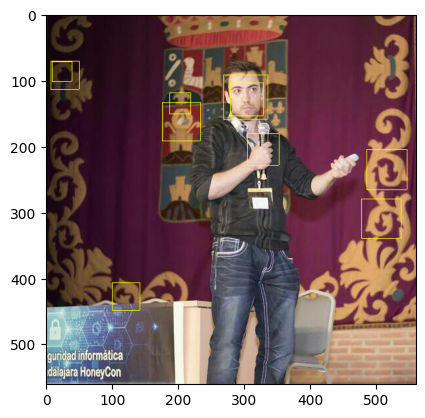

In [7]:
from mtcnn.utils.plotting import plot
import matplotlib.pyplot as plt

plt.imshow(plot(image, result))

As can be seen, the RNet is refining proposals by discarding those that do not match the thresholds, and adjusting those that matched.

### Accessing RNet's model

The network can be accessed by instantiating StageRNet and reading the attribute `model`, which is a TensorFlow model.

In [8]:
stage = StageRNet()
model = stage.model

In [9]:
model.summary()

Model: "r_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 22, 22, 28)     │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu1 (PReLU)                  │ (None, 22, 22, 28)     │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpooling1 (MaxPooling2D)      │ (None, 11, 11, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 9, 9, 48)       │        12,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu2 (PReLU)                  │ (None, 9, 9, 48)       │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpooling2 (MaxPooling2D)      │ (None, 4, 4, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 3, 3, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu3 (PReLU)                  │ (None, 3, 3, 64)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten3 (Flatten)              │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc4 (Dense)                     │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu4 (PReLU)                  │ (None, 128)            │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc5-1 (Dense)                   │ (None, 4)              │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc5-2 (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,178 (391.32 KB)

 Trainable params: 100,178 (391.32 KB)

 Non-trainable params: 0 (0.00 B)

### Loading RNet's weights

The model weights are stored within the folder local `mtcnn/assets/weights/` under the filename `rnet.lz4`. It can be loaded with `joblib`.

In [10]:
import joblib

rnet_weights = joblib.load("../mtcnn/assets/weights/rnet.lz4")

In [11]:
len(rnet_weights)

16

In [12]:
[w.shape for w in rnet_weights]

[(3, 3, 3, 28),
 (28,),
 (1, 1, 28),
 (3, 3, 28, 48),
 (48,),
 (1, 1, 48),
 (2, 2, 48, 64),
 (64,),
 (1, 1, 64),
 (576, 128),
 (128,),
 (128,),
 (128, 4),
 (4,),
 (128, 2),
 (2,)]

Further stage ablation can be performed by looking at `mtcnn/stages/stage_rnet.py`